In [1]:
library(tidyverse)
library(ggpubr)
library(treemapify)
library(vegan)
library(umap)
library(ggrepel)
library(rnaturalearth)
library(rnaturalearthdata)
library(sf)
library(ggpmisc)
library(mgcv)

source("../src/dd_functions.r")
source("../src/spreads.r")

options(jupyter.plot_scale=1)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4




This notebook contains the code for running the analyses, creating tables and figures for the following sections:
* Figure 2
* Figure 3
* Figure S8
* Figure S9
* Table S2
* Table S3

In here, we are only using R code.

In [2]:
# Set the directory of where dataframes are saved
data.dir = '../data'

# Set the directory of where figures are saved to
fig.dir = '../fig'

In [5]:
# Load in metadata for samples and ARGs
metadata <- read_csv(
    file.path(data.dir, 'metadata_fixed.csv'), 
    show_col_types=F
) %>%
    mutate(city = case_when(
            city == 'Santiago' & country == 'Spain' ~ 'Santiago_ESP',
            TRUE ~ city
        )
    )
panres.meta <- read_csv(
    file.path(data.dir, 'panres_metadata_fixed.csv'), 
    show_col_types=F
)

New names:
• `` -> `...1`


In [7]:
# Load in and format the data output of flankophile
flankophile.dat <- read_delim(
    file = file.path(data.dir, 'data', 'flankophile_output', 'initial_run', '1_hits_all.tsv'), 
    show_col_types= F
) 

flankophile.dat1 <- flankophile.dat %>%
    mutate(
        tool = case_when(
            str_detect(pattern='spades', string = METADATA) ~ 'spades',
            TRUE ~ 'seed_extender'
        ),
        sampleName = basename(`#FILE`) %>% 
            str_replace_all(
                c(
                    ".scaf.min1000.fa" = "",
                    ".scaffolds.min1000.fasta" = "",
                    "_L\\d{3}$" =  "",
                    "P1$" = "",
                    "'_S\\d{3}$" = ""
                )
            )
        #.str.replace(r'_S\d+$', '', regex=True).str.replace(r'P1$', '', regex=True)
    ) %>% 
    filter(
        tool == 'spades'
    )

flankophile.dat2 <- flankophile.dat1 %>%
    mutate(
        genepid = as.double(str_extract(sampleName, "\\d{7}")),
        gene = str_extract(GENE, 'pan_\\d+')
    ) %>%
    left_join(
        metadata %>% distinct(genepid, city, country, Region,country_alpha3, year),
        by=c("genepid"),
        na_matches = "never"
    ) %>% 
     left_join(
        metadata %>% distinct(alternative_name, city, country, Region, country_alpha3, year), 
        by=c("sampleName" = "alternative_name"),
        na_matches = "never",
        relationship="many-to-many"
    ) %>%
    mutate(
        city = case_when(
            !is.na(city.x) ~ city.x,
            TRUE ~ city.y
            ),
        country = case_when(
            !is.na(country.x) ~ country.x,
            TRUE ~ country.y
        ),
        Region = case_when(
            !is.na(Region.x) ~ Region.x,
            TRUE ~ Region.y
        ),
        country_alpha3 = case_when(
            !is.na(country_alpha3.x) ~ country_alpha3.x,
            TRUE ~ country_alpha3.y
        ),
        year = case_when(
            !is.na(year.x) ~ year.x,
            TRUE ~ year.y
        )
    ) %>%
    select(-c(city.x, city.y, country.x, country.y, Region.x, Region.y, country_alpha3.x, country_alpha3.y, year.x, year.y)) %>%
    left_join(
        panres.meta %>% distinct(gene, group, class),
        by="gene",
        na_matches = "never"
    )%>%
    filter(!is.na(group)) %>%
    unique %>%
    mutate(
        class2 = str_split(str_replace_all(class, c("'" = "", "\\[" = "", "\\]" = "", " "="")), ","),
        variant = str_c(gene, VARIANT, sep = '_'),
        city = case_when(
            city == 'Santiago' & country == 'Spain' ~ 'Santiago_ESP',
            TRUE ~ city
        )
    )

flankophile.dat3 <- flankophile.dat2 %>% unnest_longer(class2)
resClasses <- sort(unique(flankophile.dat3$class2))


In [12]:
# Coloring palettes
dbpalette <- c("Acquired" = "#FC766AFF", "FG" = "#5B84B1FF")

region_palette = list(
    'East Asia & Pacific' = '#FEFF32',
    'Europe & Central Asia' = '#4BAD49',
    'Latin America & Caribbean' = '#A75529',
    'Middle East & North Africa' = '#974EA2',
    'North America' = '#FF8000',
    'South Asia' = '#3A7EB5',
    'Sub-Saharan Africa' = '#E4191C'
)


# Spread of alleles and variants

In [8]:
spreadData <- generate_spread(
    dat1 = flankophile.dat2,
    dat2 = flankophile.dat3 %>% select(-class) %>% rename(class = class2),
    geo_levels=c("Region", "country", "city"),
    resClasses = resClasses
) %>% mutate(group=case_when(group == 'ResFinder' ~ "Acquired", T ~ "FG"))


[1] "ResFinder gene Region"


Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(geo_level)

  # Now:
  data %>% select(all_of(geo_level))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(arg_level)

  # Now:
  data %>% select(all_of(arg_level))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


[1] "ResFinder gene country"
[1] "ResFinder gene city"
[1] "ResFinder variant Region"
[1] "ResFinder variant country"
[1] "ResFinder variant city"
[1] "Functional gene Region"
[1] "Functional gene country"
[1] "Functional gene city"
[1] "Functional variant Region"
[1] "Functional variant country"
[1] "Functional variant city"


### Figure S8

Warning message in geom_segment(aes(x = dodged_x, end = dodged_x, y = 0, yend = !!sym(y)), :
“Ignoring unknown aesthetics: end”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


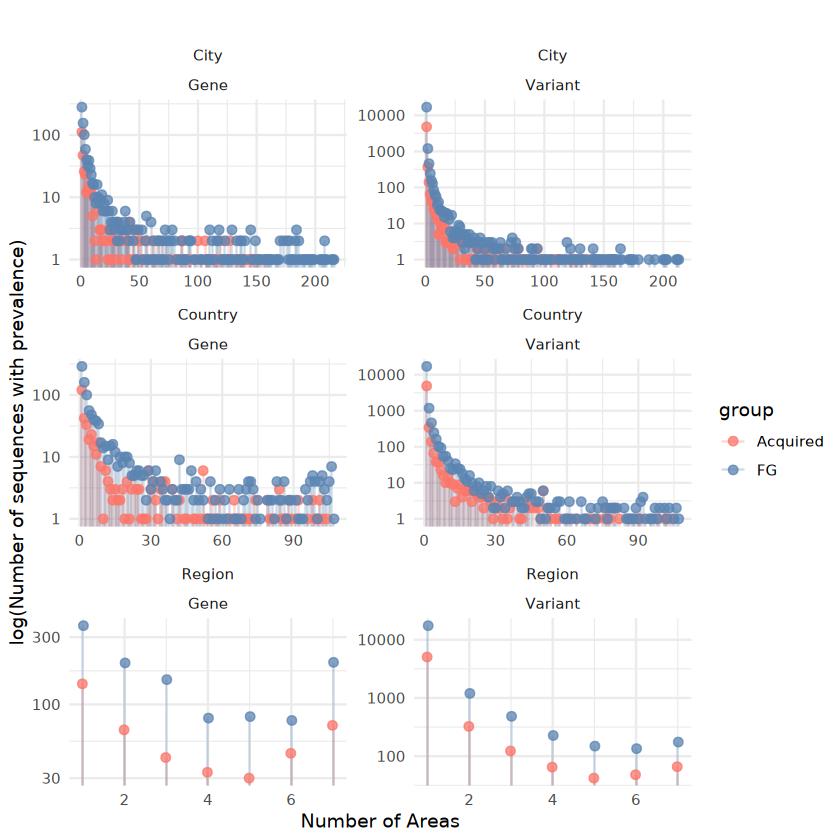

In [9]:
plot_spread(spreadData %>% filter(res_class == 'All'), palette=dbpalette, dodge_width=.05, marker_size = 2)
ggsave(
    filename=file.path(fig.dir, "all_spreads_areas_log10.png"),
    height=11.7, width=8.3
)
ggsave(
    filename=file.path(fig.dir, "all_spreads_areas_log10.pdf"),
    height=11.7, width=8.3
)

# Distance-Decays

## Distance-Decay of Quantified Resistomes (Abundances)

In [25]:
resfinder_clr <- read_csv(file.path(data.dir, 'clr_city_resfinder.csv'), show_col_types = F)
functional_clr <- read_csv(file.path(data.dir, 'clr_city_functional.csv'), show_col_types = F)
genera_clr <- read_csv(file.path(data.dir, 'clr_city_genera.csv'), show_col_types = F)

In [27]:
# Distances between cities
city_dists <- create_physical_dd(metadata, geoCol='city')

# Resistome CLR similarities with Euclidean distances
resfinder_clr_dists <- make_clr_similarity(resfinder_clr, id_col='city', method='euclidean')
functional_clr_dists <- make_clr_similarity(functional_clr, id_col='city', method='euclidean')
genera_clr_dists <- make_clr_similarity(genera_clr, id_col='city', method='euclidean')

abn.dists.regions <- city_dists %>%
    left_join(resfinder_clr_dists, by=c("area1" = "city", "area2" = "city_2")) %>%
    left_join(functional_clr_dists, by=c("area1" = "city", "area2" = "city_2"), suffix=c(".rf", ".func")) %>%
    left_join(genera_clr_dists, by=c("area1" = "city", "area2" = "city_2")) %>%
    mutate(
        across(starts_with("sim."), ~ 1 - .x, .names = "dis{.col}")
    ) %>%
    left_join(
        metadata %>% distinct(city, country, Region), by=c("area1" = "city")
    )%>%
    left_join(
        metadata %>% distinct(city, country, Region), by=c("area2" = "city"), suffix=c(".1", ".2")
    ) %>%
    filter(across(everything(), ~!is.na(.) & !is.nan(.))) %>% 
    mutate(dist_km = as.numeric(value) / 1000)

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”


### Figure 2

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in dist.mat[upper.tri(dist.mat)] <- data %>% arrange(area1, area2) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in diss.mat[upper.tri(diss.mat)] <- data %>% arrange(area1, area2) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in dist.mat[upper.tri(dist.mat)] <- data %>% arrange(area1, area2) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in diss.mat[upper.tri(diss.mat)] <- data %>% arrange(area1, area2) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_a

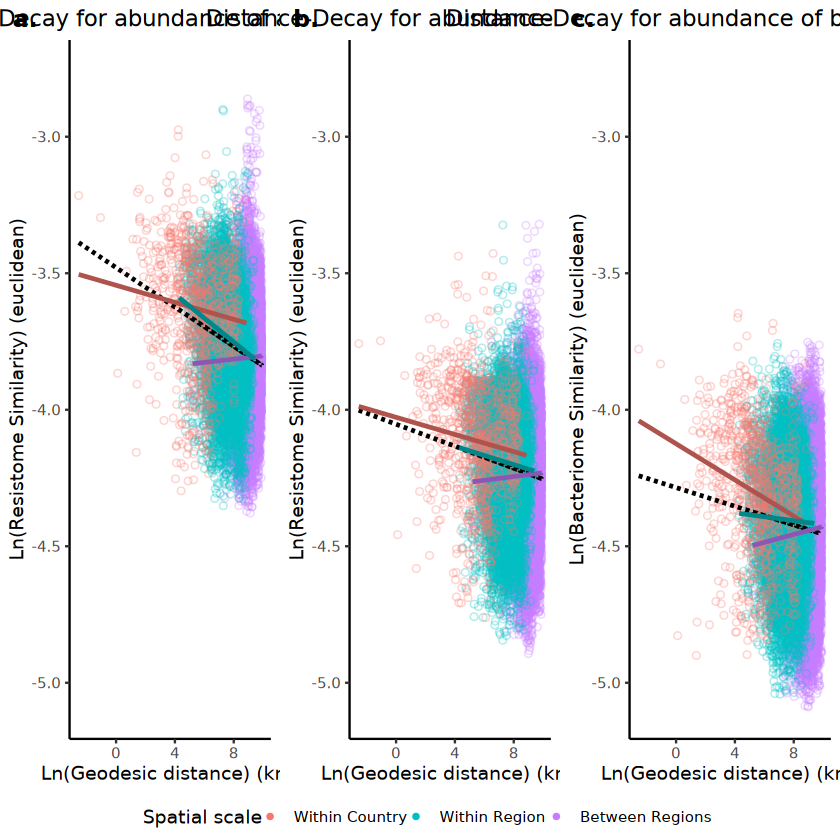

In [33]:
metric <- "euclidean"

ymin <- log(min(c(
    abn.dists.regions[[paste0("sim.", metric)]], 
    abn.dists.regions[[paste0("sim.", metric, '.rf')]], 
    abn.dists.regions[[paste0("sim.", metric, '.func')]])))
ymax <- log(max(c(
    abn.dists.regions[[paste0("sim.", metric)]], 
    abn.dists.regions[[paste0("sim.", metric, '.rf')]], 
    abn.dists.regions[[paste0("sim.", metric, '.func')]])))

p.dd.abn.rf.dist <- fit_dd_model2(
    abn.dists.regions, x='dist_km', y=paste0('dissim.', metric, '.rf'), 
    title="Distance-Decay for abundance of acquired genes",
    ylabel = paste0('Ln(Resistome Similarity) (', metric, ')'),
    ymin=ymin, ymax=ymax,
    dissim = F
)
p.dd.abn.fg.dist <-  fit_dd_model2(
    abn.dists.regions, x='dist_km', y=paste0('dissim.', metric, '.func'), 
    title="Distance-Decay for abundance of FG genes",
    ylabel = paste0('Ln(Resistome Similarity) (', metric, ')'),
    ymin=ymin, ymax=ymax,
    dissim = F
)

p.dd.abn.bac.dist <-  fit_dd_model2(
    abn.dists.regions, x='dist_km', y=paste0('dissim.', metric), 
    title="Distance-Decay for abundance of bacterial genera",
    ylabel = paste0('Ln(Bacteriome Similarity) (', metric, ')'),
    ymin=ymin, ymax=ymax,
    dissim = F
)

ggarrange(
    p.dd.abn.rf.dist$p, p.dd.abn.fg.dist$p, p.dd.abn.bac.dist$p,
    nrow=1,ncol=3,
    common.legend = T,
    legend = "bottom",
    labels = c("a.", "b.", "c.")
)

ggsave(file.path(fig.dir, paste0("dd_plots_abundances_",metric, "_sim.png")), height = 6, width = 15)

### Slopes

In [49]:
summarise_dd_model_slopes(
    p.dd.abn.rf.dist$models, 
    col_name=paste0('ResFinder', '-Variants')
) %>% column_to_rownames('spatial_scale')

,ResFinder-Variants
,<chr>
all,-0.0361*** (p-value = 0e+00)
Within Country,-0.0156** (p-value = 2.906243e-04)
Within Region,-0.0438*** (p-value = 2.526275e-100)
Between Regions,0.006*** (p-value = 4.194354e-05)


In [50]:
summarise_dd_model_slopes(
    p.dd.abn.fg.dist$models, 
    col_name=paste0('FG', '-Variants')
) %>% column_to_rownames('spatial_scale')

,FG-Variants
,<chr>
all,-0.0202*** (p-value = 3.826005e-155)
Within Country,-0.0157** (p-value = 1.481114e-04)
Within Region,-0.0167*** (p-value = 4.15489e-15)
Between Regions,0.0069*** (p-value = 6.748903e-06)


In [52]:
summarise_dd_model_slopes(
    p.dd.abn.bac.dist$models, 
    col_name=paste0('Bacteria', '-Variants')
) %>% column_to_rownames('spatial_scale')

,Bacteria-Variants
,<chr>
all,-0.0171*** (p-value = 9.468175e-88)
Within Country,-0.0331*** (p-value = 2.213936e-13)
Within Region,-0.0072* (p-value = 2.102273e-03)
Between Regions,0.0145*** (p-value = 2.010449e-16)


## Distance-Decay of Assembled Resistomes

In [10]:
resClassObjs <- c()

resClassObjs$all <- c()
resClassObjs$all$variant <-  run_all(flankophile.dat2, metadata, geneCol='variant',title=paste('Entire resistome', '-', 'exact variant'))
 resClassObjs$all$gene <-  run_all(flankophile.dat2, metadata, geneCol='gene',title=paste('Entire resistome', '-', 'closest reference'))

for(resClass in resClasses){
    sel.dat <- flankophile.dat3 %>% filter(class2 == resClass)
    print(paste(resClass))
    resClassObjs[[resClass]]$gene <- run_all(sel.dat, metadata, verbose=T, title=paste(str_to_title(resClass), '-', 'closest reference'))
    resClassObjs[[resClass]]$variant <- run_all(sel.dat, metadata, verbose=T, geneCol='variant', title=paste(str_to_title(resClass), '-', 'exact variant'))
}

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "aminoglycoside"
[1] "ResFinder data input: 6610 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 3456 29"
[1] "ResFinder distance matrix: 3 6"
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 6610 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 3456 29"
[1] "ResFinder distance matrix: 3 6"
[1] "Functional distance matrix:  "
[1] "beta_lactam"
[1] "ResFinder data input: 4879 29"
[1] "Functional data input: 23128 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 2145 6"
[1] "ResFinder data input: 4879 29"
[1] "Functional data input: 23128 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 2145 6"
[1] "fluoroquinolone"
[1] "ResFinder data input: 5 29"
[1] "Functional data input: 17142 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 528 6"
[1] "ResFinder data input: 5 29"
[1] "Functional data input: 17142 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 528 6"
[1] "folate_pathway_antagonist"
[1] "ResFinder data input: 1916 29"
[1] "Functional data input: 5488 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 1 6"
[1] "ResFinder data input: 1916 29"
[1] "Functional data input: 5488 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 1 6"
[1] "fosfomycin"
[1] "ResFinder data input: 183 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 183 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "glycopeptide"
[1] "ResFinder data input: 36 29"
[1] "Functional data input: 7523 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 28 6"
[1] "ResFinder data input: 36 29"
[1] "Functional data input: 7523 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 28 6"
[1] "lincosamide"
[1] "ResFinder data input: 4169 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix: 0 6"
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 4169 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix: 0 6"
[1] "Functional distance matrix:  "
[1] "macrolide"
[1] "ResFinder data input: 9965 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix: 78 6"
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 9965 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix: 78 6"
[1] "Functional distance matrix:  "
[1] "nitroimidazole"
[1] "ResFinder data input: 118 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 118 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "other"
[1] "ResFinder data input: 4 29"
[1] "Functional data input: 18106 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 903 6"
[1] "ResFinder data input: 4 29"
[1] "Functional data input: 18106 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 903 6"
[1] "oxazolidinone"
[1] "ResFinder data input: 148 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 148 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "peptide"
[1] "ResFinder data input: 133 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 133 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "phenicol"
[1] "ResFinder data input: 740 29"
[1] "Functional data input: 1132 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 740 29"
[1] "Functional data input: 1132 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "pleuromutilin"
[1] "ResFi

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 10 6"
[1] "ResFinder data input: 92 29"
[1] "Functional data input: 6303 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 10 6"
[1] "quinolone"
[1] "ResFinder data input: 1547 29"
[1] "Functional data input: 326 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 1547 29"
[1] "Functional data input: 326 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "rifampicin"
[1] "ResFinder data input: 221 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 221 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "streptogramin_a"
[1] "ResFinder data input: 778 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 778 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "streptogramin_b"
[1]

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 1081 6"
[1] "ResFinder data input: 2607 29"
[1] "Functional data input: 19733 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 1081 6"


In [11]:
alldists <- resClassObjs$all$variant$dists%>%
        left_join(
            metadata %>% distinct(country, city) %>% rename(area1 = city), 
            by = "area1") %>%
        left_join(
            metadata %>% distinct(country, city) %>% rename(area2 = city), 
            by = "area2", suffix = c(".1", ".2")
        )

### DD plots

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”


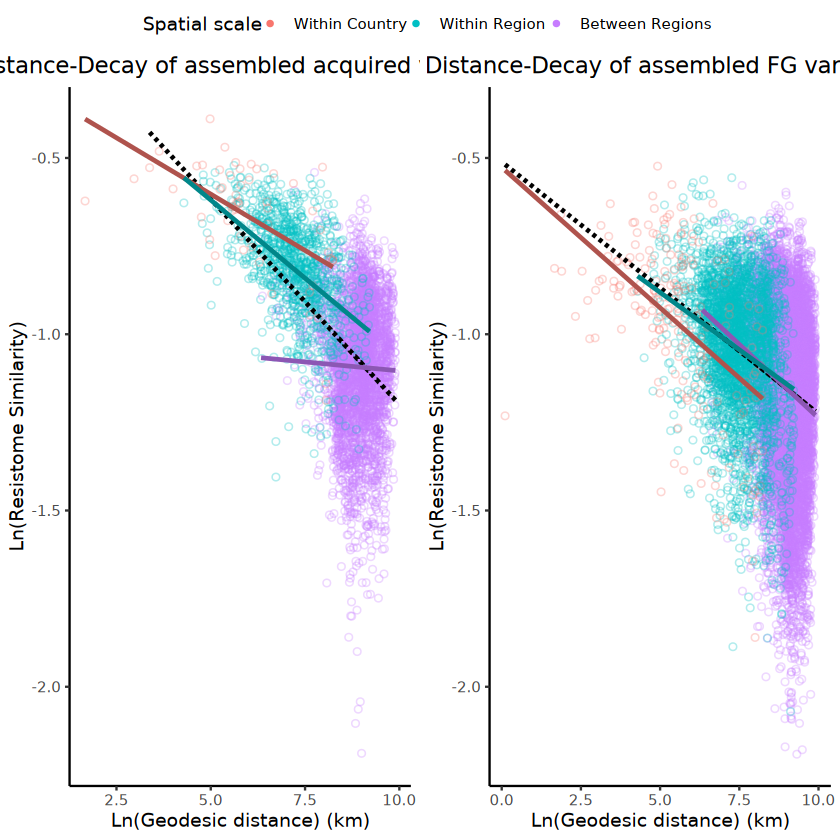

In [15]:
ymin <- log(min(1-alldists$value.res))
ymax <- log(max(1-alldists$value.res))

p.dd.rf.variants.similarity <- fit_dd_model2(
    alldists %>% filter(group == 'ResFinder'), dissim=FALSE, 
    ymin=ymin, ymax=ymax,
    title="Distance-Decay of assembled acquired variants"
)

p.dd.fg.variants.similarity <- fit_dd_model2(
    alldists %>% filter(group != 'ResFinder'), dissim=FALSE, 
    ymin=ymin, ymax=ymax,
    title="Distance-Decay of assembled FG variants"
)


ggarrange(p.dd.rf.variants.similarity$p, p.dd.fg.variants.similarity$p, ncol = 2,nrow=1, common.legend=T)

### UMAP

In [14]:
max.overlaps <- 10
legend_place = 'bottom'

umap.fontsize = 2

p.umap.variant.resfinder <- plot_umap(
    create_umap(resClassObjs$all$variant$rf.res$filtered), 
    metadata=metadata, 
    max.overlaps = max.overlaps, 
    fontsize=umap.fontsize,
    title = 'Overlap of assembled acquired variants',
    palette=region_palette
)

p.umap.variant.functional <- plot_umap(
    create_umap(resClassObjs$all$variant$func.res$filtered), 
    metadata=metadata, 
    max.overlaps = max.overlaps, 
    fontsize=umap.fontsize,
    title = 'Overlap of assembled FG variants',
    palette=region_palette
)

p.umap.variant.all <- ggarrange(
    p.umap.variant.resfinder,
    p.umap.variant.functional,
    ncol = 2,
    common.legend = T,
    labels = 'auto',
    legend = legend_place
)
#ggsave(plot = p.umap.variant.all , filename = '../figs/gene_variant_umap.png', height = 8.3, width = 11.7)


# If you want to look at closest reference match instead of individual alleles

#p.umap.gene.rf <- plot_umap(
#    create_umap(resClassObjs$all$gene$rf.res$filtered), 
#    metadata=metadata,
#    max.overlaps = max.overlaps, 
#    fontsize=umap.fontsize,
#    title = 'Overlap of assembled acquired genes',
#    palette=region_palette
#)
#p.umap.gene.fg <- plot_umap(
#    create_umap(resClassObjs$all$gene$func.res$filtered), 
#    metadata=metadata, 
#    max.overlaps = max.overlaps,
#    fontsize=umap.fontsize,
#    title = 'Overlap of assembled FG genes',
#    palette=region_palette
#)
#
#p.umap.gene.all <- ggarrange(
#    p.umap.gene.rf,
#    p.umap.gene.fg,
#    ncol = 2,
#    common.legend = T,
#    labels = 'auto',
#    legend = legend_place
#)

#ggsave(plot = p.umap.gene.all , filename = '../figs/gene_alleles_umap.png', height = 8.3, width = 11.7)

### Figure 3

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“ggrepel: 89 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 176 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 32 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 27 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


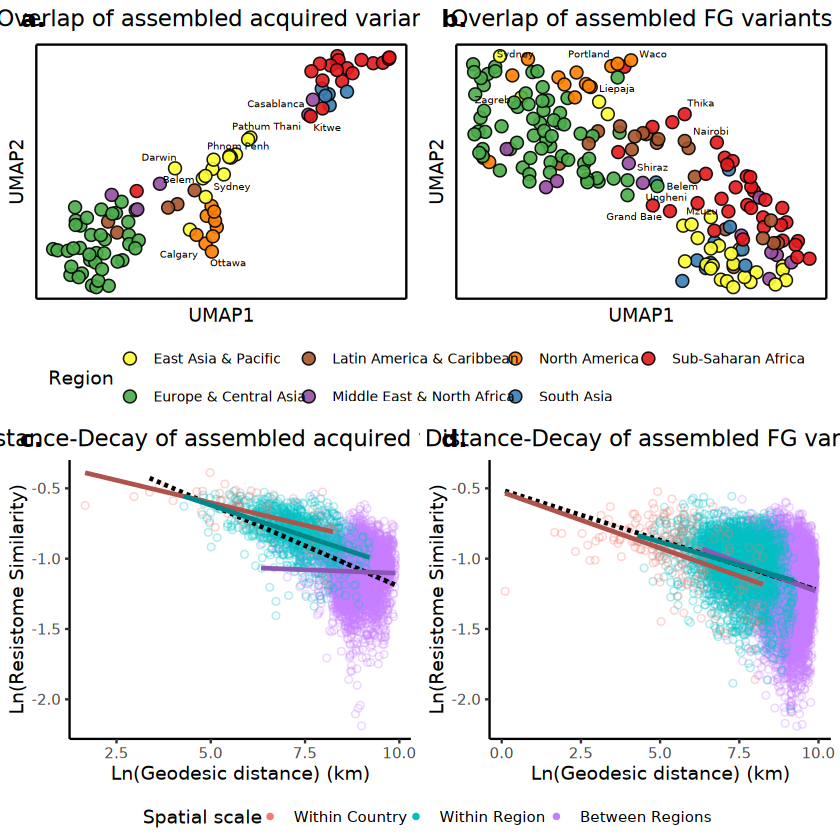

In [16]:
ggarrange(
    ggarrange(p.umap.variant.resfinder, p.umap.variant.functional, ncol=2, nrow=1, common.legend =T, labels=c("a.  ", "b.  "), legend="bottom"),
    ggarrange(p.dd.rf.variants.similarity$p, p.dd.fg.variants.similarity$p, ncol=2, nrow=1, common.legend = T, labels=c("c.  ", "d.  "), legend="bottom"),
    ncol = 1, nrow = 2
)

ggsave(
    file.path(fig.dir, "umap_dd_plots_variant_similarity.png"), 
    width = 11, height = 10
)

ggsave(
    file.path(fig.dir, "umap_dd_plots_variant_similarity.pdf"), 
    width = 11, height = 10
)

### Slopes


In [53]:
summarise_dd_model_slopes(
    p.dd.rf.variants.similarity$models, 
    col_name=paste0('ResFinder', '-Variants')
) %>% column_to_rownames('spatial_scale')

,ResFinder-Variants
,<chr>
all,-0.1166*** (p-value = 2.964394e-322)
Within Country,-0.0639*** (p-value = 5.995076e-06)
Within Region,-0.0886*** (p-value = 3.953986e-66)
Between Regions,-0.0102 (p-value = 1.07779e-01)


In [54]:
summarise_dd_model_slopes(
    p.dd.fg.variants.similarity$models, 
    col_name=paste0('FG', '-Variants')
) %>% column_to_rownames('spatial_scale')

,FG-Variants
,<chr>
all,-0.0715*** (p-value = 0e+00)
Within Country,-0.0797*** (p-value = 5.64758e-15)
Within Region,-0.0651*** (p-value = 2.824253e-56)
Between Regions,-0.0836*** (p-value = 1.70564e-102)


### DDs within each region

In [17]:
resRegionClassObjs <- c()

metadata.2 <- metadata %>%
    mutate(
        city = case_when(
            city == 'Santiago' & country == 'Spain' ~ 'Santiago_ESP',
            TRUE ~ city
        )
    )

for(region in names(region_palette)){
    resClassObjs <- c()
    
    resClassObjs$all$variant <-  run_all(flankophile.dat2[which(flankophile.dat2$Region == region),], metadata.2, geneCol='variant',title=paste('Entire resistome', '-', 'exact variant'))
     resClassObjs$all$gene <-  run_all(flankophile.dat2[which(flankophile.dat2$Region == region),], metadata.2, geneCol='gene',title=paste('Entire resistome', '-', 'closest reference'))
    
    resRegionClassObjs[[region]] <- resClassObjs
    print(region)
}
    

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "East Asia & Pacific"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "Europe & Central Asia"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "Latin America & Caribbean"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "Middle East & North Africa"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "North America"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "South Asia"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "Sub-Saharan Africa"


In [18]:
plotlist.dd.regions = list()

model_fits <- list()
for(region in names(region_palette)){
    
    alldists.region <- resRegionClassObjs[[region]]$all$variant$dists %>%
        left_join(metadata.2 %>% distinct(country, city) %>% rename(area1 = city), by = "area1") %>%
        left_join(metadata.2 %>% distinct(country, city) %>% rename(area2 = city), by = "area2", suffix = c(".1", ".2"))

    ymin <- log(min(1-alldists.region$value.res))
    ymax <- log(max(1-alldists.region$value.res))
    
    p.dd.resfinder.gene.similarity <- fit_dd_model2(
        data = alldists.region %>% filter(group == 'ResFinder'),
        ymin=log(ymin), ymax=log(ymax), 
        title=paste(region, "\n", "assembled acquired genes"),
        dissim=F
    )
    p.dd.functional.gene.similarity <- fit_dd_model2(
        data = alldists.region %>% filter(group == 'Functional'),
        ymin=log(ymin), ymax=log(ymax), 
        title="assembled FG genes",
        dissim=F
    )


    p.dd.both <- ggarrange(p.dd.resfinder.gene.similarity$p, p.dd.functional.gene.similarity$p, ncol = 1,nrow=2, common.legend=T, legend = "bottom")
    plotlist.dd.regions[[region]] <- p.dd.both

    print(
        summarise_dd_model_slopes(p.dd.resfinder.gene.similarity$models, col_name=paste0(region, '-Variants-Acquired')) %>% column_to_rownames('spatial_scale'),
        )
    print(
        summarise_dd_model_slopes(p.dd.functional.gene.similarity$models, col_name=paste0(region, '-Variants-FG')) %>% column_to_rownames('spatial_scale')
        )
    

    

}

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”


               East Asia & Pacific-Variants-Acquired
all              -0.1021*** (p-value = 3.486012e-11)
Within Country     -0.1554* (p-value = 8.126042e-03)
Within Region      -0.101*** (p-value = 2.07918e-07)
                   East Asia & Pacific-Variants-FG
all            -0.0852*** (p-value = 1.186705e-17)
Within Country    -0.068* (p-value = 9.136992e-03)
Within Region  -0.1125*** (p-value = 8.433766e-14)


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”


               Europe & Central Asia-Variants-Acquired
all                -0.0804*** (p-value = 2.632521e-36)
Within Country        -0.0256  (p-value = 2.68655e-01)
Within Region      -0.0781*** (p-value = 1.096986e-29)
                 Europe & Central Asia-Variants-FG
all             -0.063*** (p-value = 1.077794e-44)
Within Country -0.0755*** (p-value = 2.630334e-06)
Within Region  -0.0652*** (p-value = 3.328746e-32)


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message in log(ymin):
“NaNs produced”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”


               Latin America & Caribbean-Variants-Acquired
all                     -0.0894** (p-value = 1.989754e-04)
Within Country                    -0.0273  (p-value = NaN)
Within Region            -0.1572  (p-value = 3.684658e-01)
               Latin America & Caribbean-Variants-FG
all              -0.0426*** (p-value = 6.817316e-07)
Within Country      -0.0334  (p-value = 1.22663e-01)
Within Region      -0.0416** (p-value = 6.79752e-04)


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message in log(ymin):
“NaNs produced”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”


              Middle East & North Africa-Variants-Acquired
all                       -0.0369  (p-value = 6.53468e-01)
Within Region             -0.0369  (p-value = 6.53468e-01)
               Middle East & North Africa-Variants-FG
all                   -0.027* (p-value = 7.91219e-03)
Within Country       0.0642  (p-value = 5.766302e-01)
Within Region       -0.0268  (p-value = 1.233774e-01)


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”


                 North America-Variants-Acquired
all            -0.0526. (p-value = 1.640238e-02)
Within Country -0.0426  (p-value = 2.638105e-01)
Within Region  -0.0609. (p-value = 1.619695e-02)
                       North America-Variants-FG
all            -0.0279  (p-value = 3.770139e-01)
Within Country  0.0132  (p-value = 7.298689e-01)
Within Region  -0.0946  (p-value = 1.065233e-01)


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message in log(ymin):
“NaNs produced”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”


                   South Asia-Variants-Acquired
all           -0.0749  (p-value = 2.704051e-01)
Within Region -0.0749  (p-value = 2.704051e-01)
                          South Asia-Variants-FG
all            -0.0395* (p-value = 8.114146e-03)
Within Country -0.0274  (p-value = 3.210272e-01)
Within Region  -0.0552  (p-value = 1.167117e-01)


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in log(ymin):
“NaNs produced”


               Sub-Saharan Africa-Variants-Acquired
all              -0.106*** (p-value = 9.110419e-24)
Within Country    -0.0359  (p-value = 4.832577e-01)
Within Region   -0.1051*** (p-value = 1.437921e-17)
                    Sub-Saharan Africa-Variants-FG
all            -0.0475*** (p-value = 1.493094e-09)
Within Country    0.0468  (p-value = 9.517776e-02)
Within Region  -0.0525*** (p-value = 3.815835e-08)


#### Figure S9

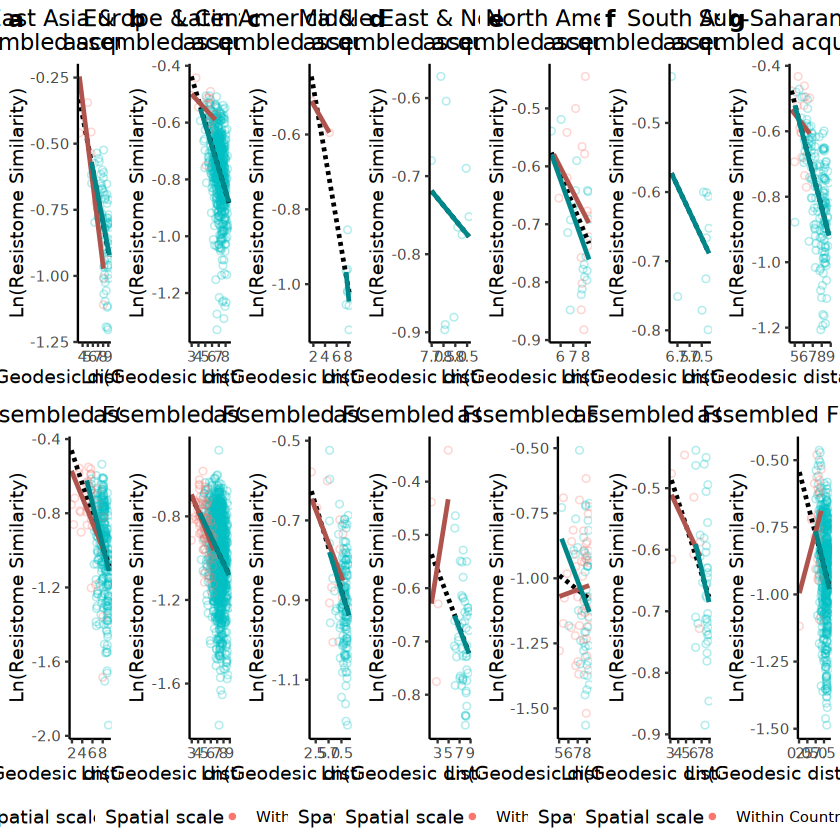

In [19]:
ggarrange(plotlist=plotlist.dd.regions, labels="auto", nrow=1)
ggsave(file.path(fig.dir, "dd_arg_variant_regions.png"), width = 20, height = 7)

## Mantel Tests

### Mantel Tests on Abundances

In [34]:
run_mantel(
    resfinder_clr %>% column_to_rownames('city'), 
    metadata,
    method = 'euclidean'
)

Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = phys.dists, ydis = res.dists) 

Mantel statistic r: 0.1107 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0338 0.0446 0.0493 0.0625 
Permutation: free
Number of permutations: 999


In [35]:
run_mantel(
    functional_clr %>% column_to_rownames('city'), 
    metadata,
    method = 'euclidean'
)

Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = phys.dists, ydis = res.dists) 

Mantel statistic r: 0.04742 
      Significance: 0.025 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0302 0.0370 0.0465 0.0561 
Permutation: free
Number of permutations: 999


In [37]:
run_mantel(
    genera_clr %>% column_to_rownames('city'), 
    metadata,
    method = 'euclidean'
)

Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


ERROR: Error in cor(as.vector(xdis), ydis, method = method, use = use): missing observations in cov/cor


### Mantel Tests on Assembled Genes

In [44]:
run_mantel(t(resClassObjs$all$variant$rf.res$filtered), metadata)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = phys.dists, ydis = res.dists) 

Mantel statistic r: 0.4454 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.142 0.190 0.233 0.269 
Permutation: free
Number of permutations: 999


In [45]:
run_mantel(t(resClassObjs$all$variant$func.res$filtered), metadata)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = phys.dists, ydis = res.dists) 

Mantel statistic r: 0.1143 
      Significance: 0.026 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0726 0.0972 0.1130 0.1381 
Permutation: free
Number of permutations: 999
